# Dimensionality reduction on noninteracting Kitaev chain

This notebook performs dimensionality reduction tecniques(PCA, Kernel PCA and T-SNE) on observables of the noninteracting Kitaev chain.

Helpful links:
https://scipost.org/SciPostPhys.14.1.005/pdf
and 
https://ml-lectures.org/docs/structuring_data/Dimensionality_reduction.html

In [1]:
import numpy as np
from numpy.linalg import norm

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib  import cm

from mpl_toolkits.axes_grid1 import make_axes_locatable


from scipy import linalg
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import svd

import sklearn as sk
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from NI_Kitaev import ki, Hamiltonian, Ek, winding_number, ck, fk
%run NI_Kitaev.py


In [2]:
delta=1.0
# define the Brillouin zone limits and resolution
k_min = -np.pi
k_max = np.pi
dk = 0.01
krange = np.arange(k_min, k_max+dk, dk)
for mu in np.arange(-3.,3.,0.5):
    print(mu)
    for k in krange:
        eig0 , _ =np.linalg.eigh(Hamiltonian(mu, delta, k))
        plt.plot(k, np.real(eig0)[0], "go")
        plt.plot(k, np.real(eig0)[1], "co")
        
#         eigs=np.linalg.eigvalsh(Hamiltonian(mu, delta, k))
#         plt.plot(k, np.real(eigs)[0], "go")
#         plt.plot(k, np.real(eigs)[1], "co")
        plt.plot(k, Ek(mu, delta, k), "b+")
        plt.plot(k, -Ek(mu, delta, k), "r+")
    plt.ylabel(r"$\epsilon$", fontsize=12)
    plt.xlabel("k", fontsize=12)
    plt.show()

In [3]:
delta=1.0
J=1.0
# define the Brillouin zone limits and resolution
k_min = -np.pi
k_max = np.pi
dk = 0.01
krange = np.arange(k_min, k_max+dk, dk)
for mu in np.arange(-3.1,3.1,1.5):
    print(mu)
    plt.plot(0,0, "rx")
    for k in krange:
        hz= J * np.cos(k) + mu/2
        hy= delta * np.sin(k)
        plt.plot(hy,hz, "bo")
    plt.ylabel(r"$h_y$", fontsize=12)
    plt.xlabel(r"$h_z$", fontsize=12)
    plt.show()

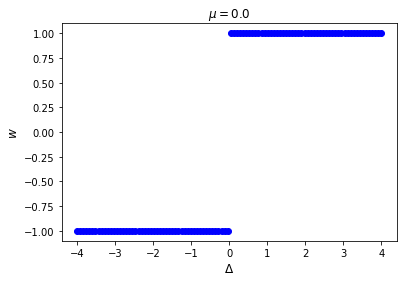

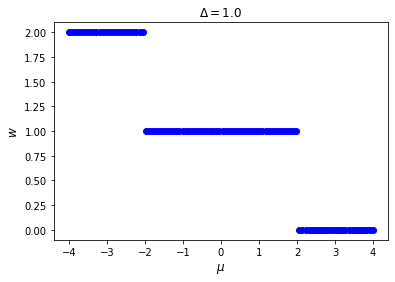

In [4]:
n_k=300
mu=0.
for delta in np.linspace(-4.0, 4.0, 100):
    plt.plot(delta, winding_number(n_k, mu, delta), 'bo')
plt.title(r"$\mu={0}$".format(mu), fontsize=12)
plt.xlabel(r"$\Delta$", fontsize=12)
plt.ylabel(r"$w$", fontsize=12)
plt.show()

delta=1.0
for mu in np.linspace(-4.0, 4.0, 100):
    plt.plot(mu, winding_number(n_k, mu, delta), 'bo')
plt.title(r"$\Delta={0}$".format(delta), fontsize=12)
plt.xlabel(r"$\mu$", fontsize=12)
plt.ylabel(r"$w$", fontsize=12)
plt.show()

In [5]:
print(ck(0.3, 1, 0.5))

0.9531106608513257


In [6]:
print(fk(0.3, 1, 0.5))

0.21140181887314724


In [32]:
L=40
Ndelta=int(4/0.1)
Nmu=int(16/0.1)

muf=8.
deltaf=2.

In [33]:
dlist=np.linspace(-deltaf, deltaf, Ndelta)
mulist=np.linspace(-muf, muf, Nmu)

In [34]:
Xmat = np.zeros((Nmu*Ndelta, 2*L))
label = np.zeros((Nmu*Ndelta))
k_grid = [ ki(l,L) for l in range(L)]
for l in tqdm(range(L)):
    k = ki(l,L)
    i=0
    for mu in mulist:
        for delta in dlist:
            if Ek(mu, delta, k)>=1.e-5:
                c=ck(mu, delta, k)
                f=fk(mu, delta, k)
                
                Xmat[i, l]= c
                Xmat[i, L+l] =f
                
                label[i] = winding_number(L, mu, delta)
                i += 1
                
X_centered = Xmat - Xmat.mean(axis=0)

100%|██████████| 40/40 [12:09<00:00, 18.24s/it]


# PCA

In [35]:
# from https://ml-lectures.org/docs/structuring_data/pca.html
def pca(X, n_components):
    
    # Center the data by subtracting from each column the mean of that column
    X_centered = X - X.mean(axis=0)
    
    # Form the n by n covariance matrix
    C = np.cov(X.T)
    
    # Diagonalize the matrix 
    L, W = np.linalg.eig(C)
    
    # Sort the eigenvalues and vectors from largest to smallest
    idx = L.argsort()[::-1]   
    L = L[idx]
    W = W[:,idx]
    
    # Keep only the n_components largest eigenvectors
    Wtilde = W[:, :n_components]
    
    # Transform initial data
    X_pca = X_centered.dot(Wtilde)
    
    return X_pca

In [36]:
# Center the data by subtracting from each column the mean of that column
X_centered = Xmat - Xmat.mean(axis=0)
    
# Form the n by n covariance matrix
C = np.cov(Xmat.T)

# Diagonalize the matrix 
lam, W = np.linalg.eig(C)

EVR = lam/np.sum(lam)

In [37]:
# Select number of components
n_components = 4

# Apply our pca function
X_pca = pca(Xmat, n_components)
# print(np.real(X_pca))

In [38]:
batch_size = 1            
Pi=[]
for i in range(n_components):
    Wi = W[:,i]
    s=0
    j=0
    pi=0
    for mu in mulist:
        for delta in dlist:
            Xs = X_centered[j]
            pi += np.abs(Xs.dot(Wi))/batch_size
            if s==batch_size-1:
                Pi.append( [i, mu, delta, pi])
                pi=0
                j +=1
                s=0
            else:
                s +=1 

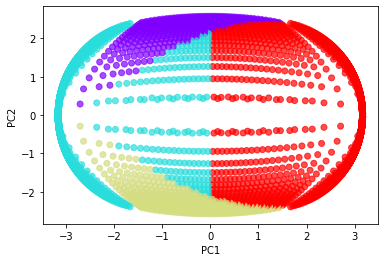

In [39]:
skl_pca = PCA(n_components)
X_skl_pca = skl_pca.fit_transform(Xmat)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_skl_pca[:,0],
    X_skl_pca[:,1],
    c=label,
    cmap='rainbow',
    alpha=0.7,
#     edgecolors='b'
)

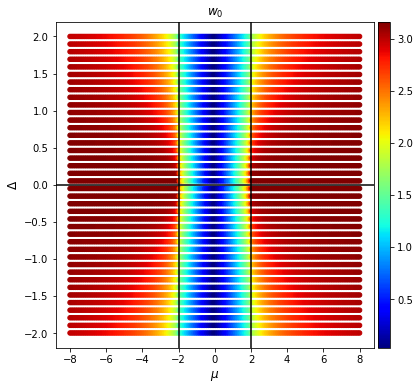

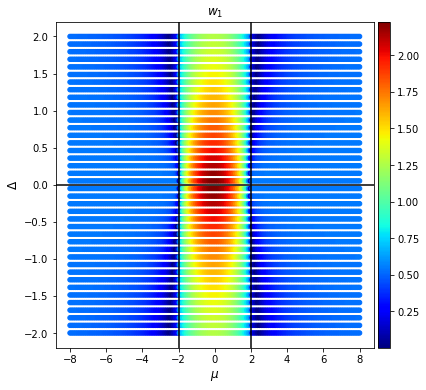

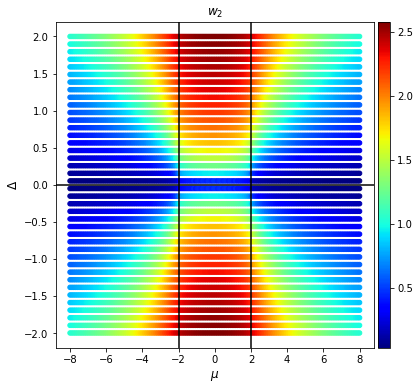

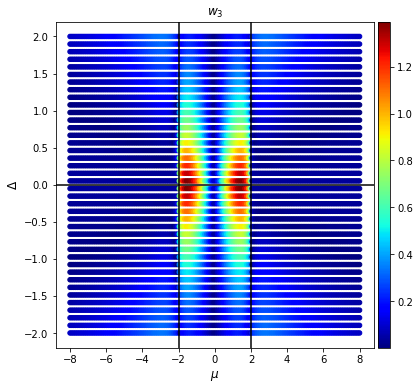

In [40]:
for i in range(n_components):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)

    ax.set_title(r"$w_{0}$".format(i),fontsize=12)
    ax.set_xlabel(r"$\mu$",fontsize=12)
    ax.set_ylabel(r"$\Delta$",fontsize=12)

    x = [item[1] for item in Pi if item[0]==i]
    y = [item[2] for item in Pi if item[0]==i]
    z = [item[3] for item in Pi if item[0]==i]

    # print(np.unique(z))

    # scatter with colormap mapping to z value
    im = ax.scatter(x,y,s=20,c=z, marker = 'o', cmap = cm.jet )
    ax.axvline(x=-2, c="black")
    ax.axvline(x=2, c="black")
    ax.axhline(y=0, c="black")
    
    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.show()

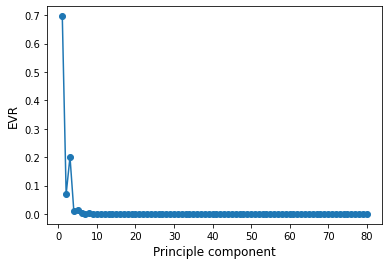

In [41]:
plt.plot(np.arange(1,len(lam)+1), np.abs(EVR), "-o")
plt.ylabel("EVR", fontsize=12)
plt.xlabel("Principle component", fontsize=12)
plt.show()

In [42]:
print(np.round((1 - np.sum(np.abs(EVR[:n_components])))*100,1),"%")

2.4 %


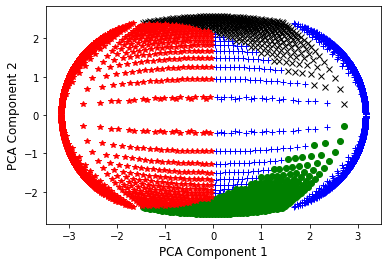

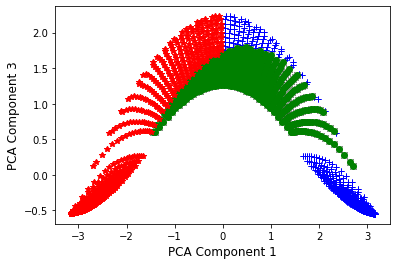

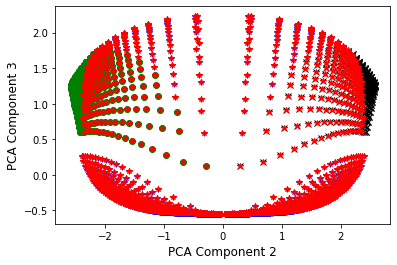

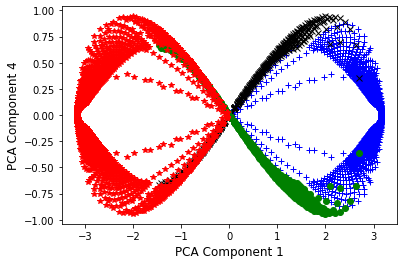

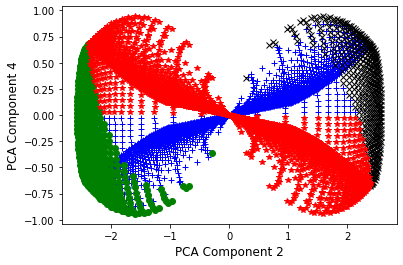

In [43]:
# Get class labels as marker style for the plot
idx_0 = np.where(label==0)
idx_1 = np.where(label==1)
idx_2 = np.where(label==-1)
idx_3 = np.where(label==2)

# # Now lets look at the compressed version..
plt.plot(np.real(X_pca[idx_0, 0]), np.real(X_pca[idx_0, 1]), "b+", label="0")
plt.plot(np.real(X_pca[idx_1, 0]), np.real(X_pca[idx_1, 1]), "kx", label="1")
plt.plot(np.real(X_pca[idx_2, 0]), np.real(X_pca[idx_2, 1]), "go", label="-1")
plt.plot(np.real(X_pca[idx_3, 0]), np.real(X_pca[idx_3, 1]), "r*", label="2")
plt.ylabel("PCA Component 2", fontsize=12)
plt.xlabel("PCA Component 1", fontsize=12)
plt.show()

# # Now lets look at the compressed version..
plt.plot(np.real(X_pca[idx_0, 0]), np.real(X_pca[idx_0, 2]), "b+", label="0")
plt.plot(np.real(X_pca[idx_1, 0]), np.real(X_pca[idx_1, 2]), "kx", label="1")
plt.plot(np.real(X_pca[idx_2, 0]), np.real(X_pca[idx_2, 2]), "go", label="-1")
plt.plot(np.real(X_pca[idx_3, 0]), np.real(X_pca[idx_3, 2]), "r*", label="2")
plt.ylabel("PCA Component 3", fontsize=12)
plt.xlabel("PCA Component 1", fontsize=12)
plt.show()


# # Now lets look at the compressed version..
plt.plot(np.real(X_pca[idx_0, 1]), np.real(X_pca[idx_0, 2]), "b+", label="0")
plt.plot(np.real(X_pca[idx_1, 1]), np.real(X_pca[idx_1, 2]), "kx", label="1")
plt.plot(np.real(X_pca[idx_2, 1]), np.real(X_pca[idx_2, 2]), "go", label="-1")
plt.plot(np.real(X_pca[idx_3, 1]), np.real(X_pca[idx_3, 2]), "r*", label="2")
plt.ylabel("PCA Component 3", fontsize=12)
plt.xlabel("PCA Component 2", fontsize=12)
plt.show()

# # Now lets look at the compressed version..
plt.plot(np.real(X_pca[idx_0, 0]), np.real(X_pca[idx_0, 3]), "b+", label="0")
plt.plot(np.real(X_pca[idx_1, 0]), np.real(X_pca[idx_1, 3]), "kx", label="1")
plt.plot(np.real(X_pca[idx_2, 0]), np.real(X_pca[idx_2, 3]), "go", label="-1")
plt.plot(np.real(X_pca[idx_3, 0]), np.real(X_pca[idx_3, 3]), "r*", label="2")
plt.ylabel("PCA Component 4", fontsize=12)
plt.xlabel("PCA Component 1", fontsize=12)
plt.show()

# # Now lets look at the compressed version..
plt.plot(np.real(X_pca[idx_0, 1]), np.real(X_pca[idx_0, 3]), "b+", label="0")
plt.plot(np.real(X_pca[idx_1, 1]), np.real(X_pca[idx_1, 3]), "kx", label="1")
plt.plot(np.real(X_pca[idx_2, 1]), np.real(X_pca[idx_2, 3]), "go", label="-1")
plt.plot(np.real(X_pca[idx_3, 1]), np.real(X_pca[idx_3, 3]), "r*", label="2")
plt.ylabel("PCA Component 4", fontsize=12)
plt.xlabel("PCA Component 2", fontsize=12)
plt.show()


# Kernel PCA

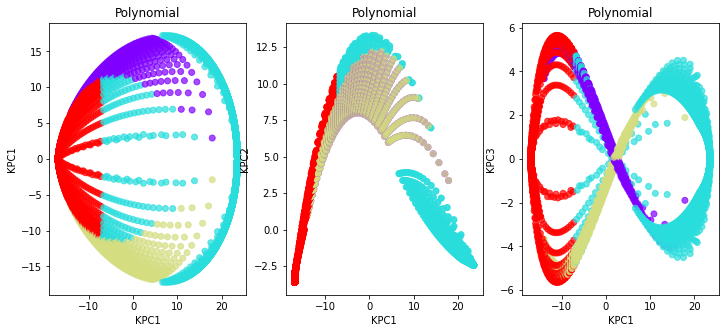

In [44]:
# Polynomial Kernel
kpca_poly = KernelPCA(n_components=n_components, kernel='poly', degree=2, gamma=1, coef0=0.5)
X_kpca_poly = kpca_poly.fit_transform(Xmat)

fig, ax = plt.subplots(1, n_components-1, figsize=(12,5))
for i in range(n_components-1):
    ax[i].set_xlabel('KPC1')
    ax[i].set_ylabel('KPC{0}'.format(i+1))
    ax[i].set_title("Polynomial")
    ax[i].scatter(
        X_kpca_poly[:,0],
        X_kpca_poly[:,i+1],
        c=label,
        cmap='rainbow',
        alpha=0.7,
    #     edgecolors='b'
    )
  

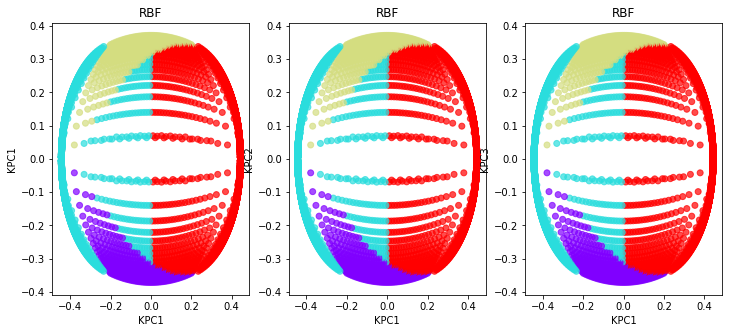

In [45]:
# RBF Kernel
kpca_rbf = KernelPCA(n_components=3, kernel='rbf')
X_kpca_rbf = kpca_rbf.fit_transform(Xmat)

fig, ax = plt.subplots(1, n_components-1, figsize=(12,5))
for i in range(n_components-1):
    ax[i].set_xlabel('KPC1')
    ax[i].set_ylabel('KPC{0}'.format(i+1))
    ax[i].set_title("RBF")
    ax[i].scatter(
        X_kpca_rbf[:,0],
        X_kpca_rbf[:,1],
        c=label,
        cmap='rainbow',
        alpha=0.7,
    #     edgecolors='b'
    )

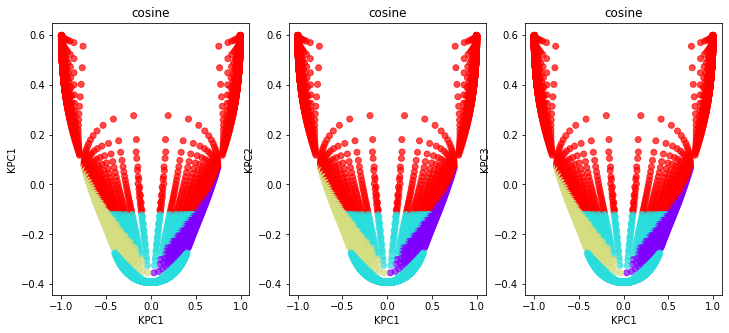

In [46]:
# cosine Kernel
kpca_rbf = KernelPCA(n_components=3, kernel='cosine')
X_kpca_rbf = kpca_rbf.fit_transform(Xmat)

fig, ax = plt.subplots(1, n_components-1, figsize=(12,5))
for i in range(n_components-1):
    ax[i].set_xlabel('KPC1')
    ax[i].set_ylabel('KPC{0}'.format(i+1))
    ax[i].set_title("cosine")
    ax[i].scatter(
        X_kpca_rbf[:,0],
        X_kpca_rbf[:,1],
        c=label,
        cmap='rainbow',
        alpha=0.7,
    #     edgecolors='b'
    )

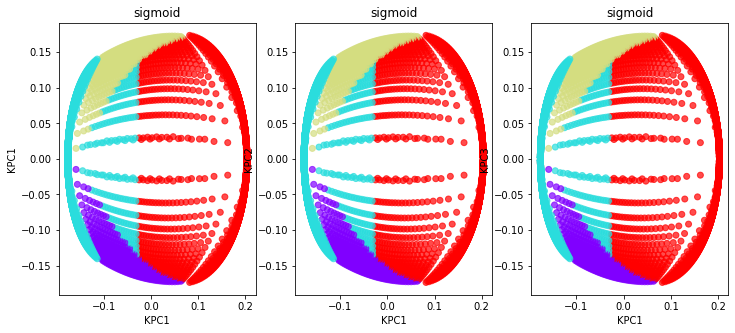

In [47]:
# sigmoid Kernel
kpca_rbf = KernelPCA(n_components=3, kernel='sigmoid')
X_kpca_rbf = kpca_rbf.fit_transform(Xmat)

fig, ax = plt.subplots(1, n_components-1, figsize=(12,5))
for i in range(n_components-1):
    ax[i].set_xlabel('KPC1')
    ax[i].set_ylabel('KPC{0}'.format(i+1))
    ax[i].set_title("sigmoid")
    ax[i].scatter(
        X_kpca_rbf[:,0],
        X_kpca_rbf[:,1],
        c=label,
        cmap='rainbow',
        alpha=0.7,
    #     edgecolors='b'
    )

# T-SNE

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.000s...
[t-SNE] Computed neighbors for 6400 samples in 1.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.086481
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.374458
[t-SNE] KL divergence after 600 iterations: 0.320164


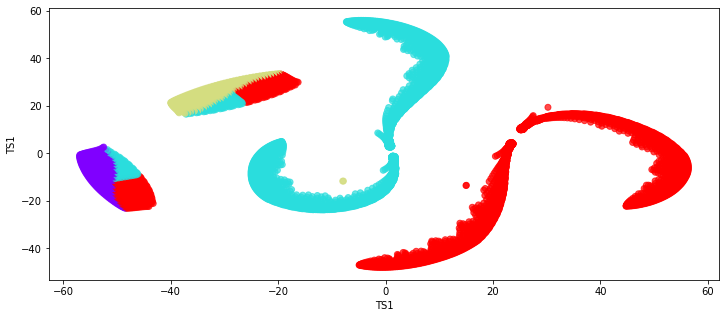

In [48]:
n_components_tsne=2
tsne = TSNE(n_components=n_components_tsne, verbose=1, perplexity=100, learning_rate=800, n_iter=600)
tsne_results = tsne.fit_transform(Xmat)

fig, ax = plt.subplots(1, n_components_tsne-1, figsize=(12,5))
for i in range(n_components_tsne-1):
    ax.set_xlabel('TS1')
    ax.set_ylabel('TS{0}'.format(i+1))
    ax.scatter(
        tsne_results[:,0],
        tsne_results[:,i+1],
        c=label,
        cmap='rainbow',
        alpha=0.7,
    #     edgecolors='b'
    )